# Predict cases_recovered

Import libraries and file path

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

#ignore warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=FutureWarning)

%matplotlib inline
filepath = 'cases_malaysia.csv'

# Classes

Plot and print error metric

In [ ]:
def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

In [ ]:
#----------Plot Prediction against Actual---------------
def plotPredAct_plot(title, train, train_pred, test, test_pred, row_num, col_num, counterTitle=None, counterList=[], ):
    fig, axs = plt.subplots(row_num * 2, col_num, sharex='col', sharey='row')
    clr = ['blue', 'red']
    lbl = ['train', 'test']
    
    for i in range(col_num):
        for j in range(row_num):
            for k in range(2):
                data = [train[i * 2 + j], test[i * 2 + j]]
                pred = [train_pred[i * 2 + j], test_pred[i * 2 + j]]
                if col_num == 1:
                    ax = axs[k + j * 2]
                else:
                    ax = axs[k + j * 2, i]
                #show only one legends
                if i == 0 and j == 0:
                    label = lbl[k]
                else:
                    label = '_nolegend_'
                if k == 0 and counterTitle != None: 
                    subTitle = counterTitle + str(counterList[i * 2 + j])
                    ax.set_title(subTitle, fontsize='small')
                ax.scatter(data[k], pred[k], s=5, c=clr[k], label=label)
                ax.label_outer()
            
    #set title, axis title
    fig.legend(loc='lower right')
    fig.suptitle(str(title))
    fig.supylabel('predicted cases')
    fig.supxlabel('actual cases')
    fig.tight_layout()
    plt.show()

In [ ]:
def plotPredAct(X_train, X_test, y_train, y_test, fit_model, title, subtitle, loop_range, row_num, col_num, isDegree=False):
    train_plt, train_pred_plt, test_plt, test_plt = [], [], [], []
    counter = []
    for i in loop_range:
        degree = i
        counter.append(degree)
        if(isDegree==False):
            y_train_pred, y_test_pred =  fit_model(X_train, X_test, y_train, y_test)
        else:
            y_train_pred, y_test_pred =  fit_model(degree, X_train, X_test, y_train, y_test)
        train_plt.append(train[label_cols])
        train_pred_plt.append(y_train_pred)
        test_plt.append(test[label_cols])
        test_plt.append(y_test_pred)

    plotPredAct_plot(title, train_plt, train_pred_plt, test_plt, test_plt, row_num, col_num, subtitle, counter)

Skew Logarithm Transform

In [ ]:
def skewTrans(skew_limit=0.75, train=None, target=None):
    skew_vals = train.skew() #save skew value into a list
    mask = (skew_vals >= skew_limit) & (skew_vals.index != str(target)) #create skew mask >= 0.75
    skew_cols = skew_vals[mask] #filter column index with the mask
    
    log_train = train.copy()  #make a copy
    #apply transform to one that exceed skew_limit
    for item in train[skew_cols.index]:
        log_train[item] = np.log1p(log_train[item])
    
    return pd.DataFrame(log_train) #return log transformed list

Split test, train and feature, label
Before spliting the testing and training features are scalled by given scaler

In [ ]:
def split_sc(train, test, feature_cols, label_cols, scaler=None):
    if(scaler==None): #if no scaler, just split it
        return train[feature_cols], test[feature_cols], train[label_cols], test[label_cols]
    
    #if scaler is available, scaled it before spliting the test train data
    X_train_scale = scaler.fit_transform(train[feature_cols])
    X_test_scale = scaler.transform(test[feature_cols])
    return X_train_scale, X_test_scale, train[label_cols], test[label_cols]

Error metric

In [ ]:
#print error metric where:
#raw: data without preprocessing, log: data being logarithm transformed, mm_sc: MinMaxScaler(), 
#ss_sc: StandardScaler(), ma_sc: MaxAbsScaler()
def errorMetrics(fit_model, title, coefficient=None):
    cols = ['raw', 'log', 'mm_sc','mm_sc+log', 'ss_sc', 'ss_sc+log', 'ma_sc', 'ma_sc+log']
    models = [None, MinMaxScaler(), StandardScaler(), MaxAbsScaler()]
    trains = [train, log_train]
    tests = [test, log_test]
    
    label_cols = 'cases_recovered' #target column
    feature_cols = [x for x in train.columns if x != label_cols] #feature column

    rmses = pd.DataFrame() #create rmse data frame
    
    for i in range(0, 4):
        for j in range(0, 2):
            X_train, X_test, y_train, y_test = split_sc(trains[j], tests[j], feature_cols, label_cols, models[i])
            #fit trainning and testing data into model
            if coefficient == None:
                y_train_pred, y_test_pred =  fit_model(X_train, X_test, y_train, y_test)
            else:
                y_train_pred, y_test_pred =  fit_model(coefficient, X_train, X_test, y_train, y_test)

            #append error metric
            new_rmses = pd.Series()
            new_rmses['train'] = rmse(y_train_pred, y_train)
            new_rmses['test'] = rmse(y_test_pred, y_test)
            rmses[cols[i* 2 + j]] = pd.Series(new_rmses)
    
    rmses_out = rmses.style.set_caption(str(title)).format('{:.2e}')
                                               
    #return error metric with style
    return rmses_out

### used to test errorMetrics()

display(errorMetrics(knn_reg,'RMSE | KNN (K=' + str(K) + ')' , K))

# Initialization

Check shape of raw data

In [ ]:
df = pd.read_csv(filepath)
print("Row & Column of " + str(filepath) + ": " + str(df.shape))

Get data from March 2021 to Auguest 2021

In [ ]:
#convert date string to date object in dataframe
df['date'] = pd.to_datetime(df['date'])

#get data from March 2021 to Auguest 2021
date_mask = (df['date'] >= "2021-03-01") & (df['date'] <= "2021-08-31")
df_masked = df.loc[date_mask]

print("Row & Column of data from March 2021 to Auguest 2021: " + str(df_masked.shape))

Explore each column, check if any data is null

In [ ]:
df_sum = pd.isnull(df_masked) 
df_sum.sum()

Check column type of the data

In [ ]:
df_masked.columns

Seperate data into features and labels.

In [ ]:
data = df_masked.copy() #copy the whole data range 
del data['date'] #drop date column

train, test = train_test_split(data, test_size=0.3, random_state=42) #split train test data
label_cols = 'cases_recovered' #target column
feature_cols = [x for x in train.columns if x != label_cols] #feature columns

Check the skewness before and after the logarithm transform on the features

In [ ]:
skew_limit = 0.75
#log transform the train and test date excluding 'cases_recovered'
log_train = skewTrans(skew_limit, train, 'cases_recovered')
log_test = skewTrans(skew_limit, test, 'cases_recovered')
#display transformed and original skew list of train data
skew_list = pd.DataFrame()
skew_list['transformed'] = log_train.skew()
skew_list['original'] = train.skew()
skew_list

<Axes: title={'center': 'log'}>

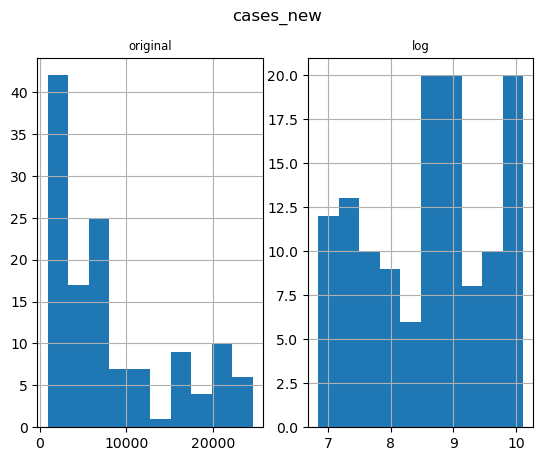

In [31]:
#display histogram of 'cases_new' before and after log transform
fig, axs = plt.subplots(1, 2)
fig.suptitle('cases_new')
axs[0].set_title('original', size='small')
axs[1].set_title('log', size='small')
train['cases_new'].hist(ax=axs[0])
log_train['cases_new'].hist(ax=axs[1])

## K-Nearest Neighbor Regression

In [32]:
def knn_reg(K, X_train, X_test, y_train, y_test):
    #Create a N-Nearest Neighbors classifier of 5 neighbors
    knn = KNeighborsRegressor(n_neighbors=K)

    #Fill the model to the training set
    knn.fit(X_train, y_train)

    #prediction on the test set
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    return (y_train_pred, y_test_pred)

Generate table of RMSE with KNN model

In [16]:
for i in range(1, 23, 3):
    K = i
    display(errorMetrics(knn_reg,'RMSE | KNN (K=' + str(K) + ')' , K))

,raw,log,mm_sc,mm_sc+log,ss_sc,ss_sc+log,ma_sc,ma_sc+log
train,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
test,8.16e+02,2.87e+03,1.40e+03,2.33e+03,1.42e+03,2.54e+03,1.39e+03,4.25e+03


,raw,log,mm_sc,mm_sc+log,ss_sc,ss_sc+log,ma_sc,ma_sc+log
train,6.88e+02,1.90e+03,7.21e+02,9.08e+02,6.74e+02,9.78e+02,7.21e+02,1.07e+03
test,8.35e+02,2.72e+03,8.38e+02,1.95e+03,1.05e+03,1.60e+03,8.43e+02,3.89e+03


,raw,log,mm_sc,mm_sc+log,ss_sc,ss_sc+log,ma_sc,ma_sc+log
train,8.03e+02,2.23e+03,8.03e+02,1.05e+03,8.04e+02,1.14e+03,8.10e+02,1.27e+03
test,7.75e+02,2.60e+03,9.51e+02,1.53e+03,9.35e+02,1.53e+03,9.60e+02,3.65e+03


,raw,log,mm_sc,mm_sc+log,ss_sc,ss_sc+log,ma_sc,ma_sc+log
train,8.74e+02,2.37e+03,8.21e+02,1.11e+03,8.70e+02,1.22e+03,8.17e+02,1.30e+03
test,7.98e+02,2.51e+03,9.12e+02,1.40e+03,8.89e+02,1.49e+03,9.31e+02,3.61e+03


,raw,log,mm_sc,mm_sc+log,ss_sc,ss_sc+log,ma_sc,ma_sc+log
train,9.43e+02,2.39e+03,8.93e+02,1.24e+03,9.08e+02,1.32e+03,8.79e+02,1.40e+03
test,8.44e+02,2.43e+03,9.77e+02,1.42e+03,1.02e+03,1.44e+03,1.00e+03,3.59e+03


,raw,log,mm_sc,mm_sc+log,ss_sc,ss_sc+log,ma_sc,ma_sc+log
train,9.77e+02,2.48e+03,9.61e+02,1.39e+03,9.65e+02,1.45e+03,9.60e+02,1.48e+03
test,8.43e+02,2.42e+03,9.97e+02,1.37e+03,1.04e+03,1.49e+03,9.81e+02,3.50e+03


,raw,log,mm_sc,mm_sc+log,ss_sc,ss_sc+log,ma_sc,ma_sc+log
train,1.05e+03,2.61e+03,1.05e+03,1.43e+03,1.05e+03,1.61e+03,1.05e+03,1.58e+03
test,8.99e+02,2.52e+03,1.05e+03,1.36e+03,1.02e+03,1.46e+03,1.06e+03,3.42e+03


,raw,log,mm_sc,mm_sc+log,ss_sc,ss_sc+log,ma_sc,ma_sc+log
train,1.17e+03,2.60e+03,1.19e+03,1.57e+03,1.19e+03,1.67e+03,1.18e+03,1.69e+03
test,9.52e+02,2.57e+03,1.09e+03,1.41e+03,1.11e+03,1.54e+03,1.09e+03,3.29e+03


Generate plots of predicted vs actual cases with KNN models

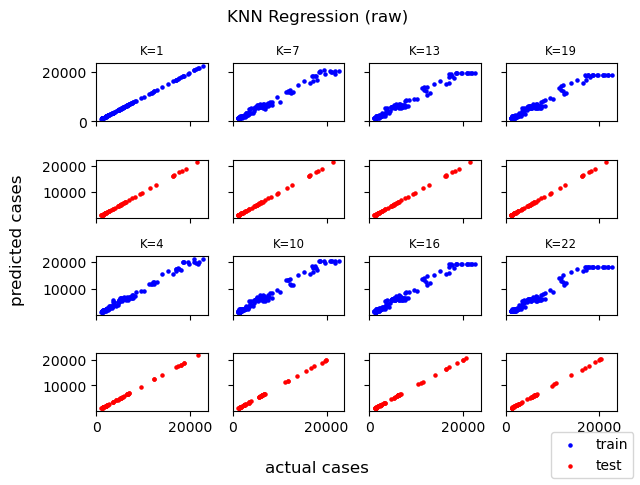

In [17]:
X_train, X_test, y_train, y_test = split_sc(train, test, feature_cols, label_cols, None)
plotPredAct(X_train, X_test, y_train, y_test, knn_reg, 'KNN Regression (raw)', 'K=', range(1, 23, 3), 2, 4, True)

## Polynomial Regression

In [18]:
def poly_reg(degree, X_train, X_test, y_train, y_test):
    pf = PolynomialFeatures(degree=degree, include_bias=False) #creating an instance of PolynomialFeature
    poly_model = LinearRegression() #create an instance of LinearRegression
    
    # transform the train and test data into polynomial form
    poly_X_train = pf.fit_transform(X_train)
    poly_X_test = pf.fit_transform(X_test)
    
    # train the model
    poly_model.fit(poly_X_train, y_train)
    
    # prediction
    y_train_pred = poly_model.predict(poly_X_train)
    y_test_pred = poly_model.predict(poly_X_test)
    
    return (y_train_pred, y_test_pred)

Get RMSE with linear model

In [19]:
X_train, X_test, y_train, y_test = split_sc(train, test, feature_cols, label_cols, None)
y_train_pred, y_test_pred = poly_reg(1, X_train, X_test, y_train, y_test)
Linear_rmse = rmse(y_test_pred, y_test)

Generate table of RMSE with Polynomial model

In [20]:
for i in range(1, 5):
    degree = i
    display(errorMetrics(poly_reg, 'RMSE | Polynomial Regression(degree=' + str(degree)+')',degree))

,raw,log,mm_sc,mm_sc+log,ss_sc,ss_sc+log,ma_sc,ma_sc+log
train,8.84e+02,1.09e+03,8.84e+02,1.09e+03,8.84e+02,1.09e+03,8.84e+02,1.09e+03
test,9.38e+02,9.54e+03,9.38e+02,9.54e+03,9.38e+02,9.54e+03,9.38e+02,9.54e+03


,raw,log,mm_sc,mm_sc+log,ss_sc,ss_sc+log,ma_sc,ma_sc+log
train,1.66e-07,7.66e-08,3.60e-11,2.56e-11,3.07e-11,4.86e-11,5.42e-11,8.51e-11
test,5.15e+03,3.02e+04,2.62e+03,5.04e+03,2.70e+03,7.33e+03,2.63e+03,1.03e+04


,raw,log,mm_sc,mm_sc+log,ss_sc,ss_sc+log,ma_sc,ma_sc+log
train,1.01e-06,1.08e-08,1.33e-10,5.50e-11,7.55e-11,3.84e-11,8.30e-11,6.41e-11
test,5.48e+04,3.27e+05,2.29e+03,4.64e+03,2.27e+03,3.41e+03,2.33e+03,4.50e+03


,raw,log,mm_sc,mm_sc+log,ss_sc,ss_sc+log,ma_sc,ma_sc+log
train,3.62e-06,1.18e-06,3.86e-10,9.54e-11,1.77e-10,1.77e-10,1.01e-09,1.07e-10
test,7.34e+05,9.98e+05,2.85e+03,3.54e+03,4.66e+03,3.06e+03,2.54e+03,2.51e+03


Generate plots of predicted vs actual cases with Polynomial models with raw data

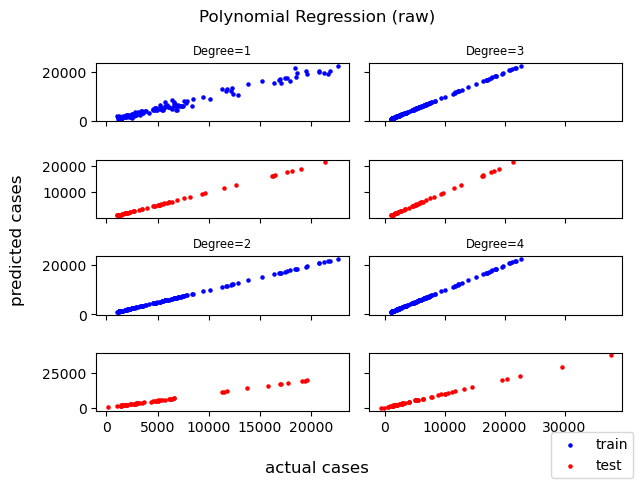

In [21]:
X_train, X_test, y_train, y_test = split_sc(train, test, feature_cols, label_cols, None)
plotPredAct(X_train, X_test, y_train, y_test, poly_reg, 'Polynomial Regression (raw)', 'Degree=', range(1, 5), 2, 2, True)

## Logistic Regression

In [22]:
def log_reg(X_train, X_test, y_train, y_test):

    log = LogisticRegression()
    log_model = log.fit(X_train, y_train)

    y_train_pred = log_model.predict(X_train)
    y_test_pred = log_model.predict(X_test)

    return (y_train_pred, y_test_pred)

Generate table of RMSE with Polynomial model

In [23]:
display(errorMetrics(log_reg, 'RMSE | Logistic Regression'))

,raw,log,mm_sc,mm_sc+log,ss_sc,ss_sc+log,ma_sc,ma_sc+log
train,3.31e+03,1.91e+03,2.45e+03,2.20e+03,2.00e+02,9.99e+00,2.47e+03,2.91e+03
test,3.71e+03,5.56e+03,2.64e+03,1.83e+03,1.39e+03,2.11e+03,2.64e+03,3.30e+03


Generate plots of predicted vs actual cases with Logistic models

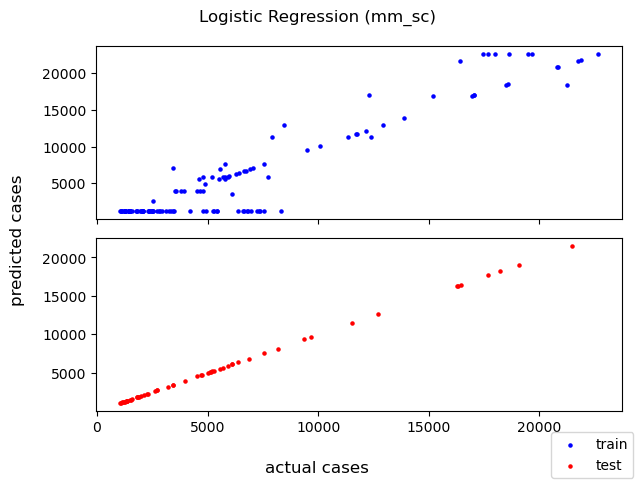

In [24]:
X_train, X_test, y_train, y_test = split_sc(train, test, feature_cols, label_cols, MinMaxScaler())
plotPredAct(X_train, X_test, y_train, y_test, log_reg, 'Logistic Regression (mm_sc)', None, range(1, 2), 1, 1, False)

# Searching Hyperparameters for SGD Regression

### Ridge Regression

Calculate the hyperparameters and RMSE with RidgeCV

In [25]:
X_train, X_test, y_train, y_test = split_sc(train, test, feature_cols, label_cols, None)
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]
ridge_cv = RidgeCV(alphas=alphas, cv=4).fit(X_train, y_train)
ridge_cv_rmse = rmse(y_test, ridge_cv.predict(X_test))
print('alpha: ' + str(ridge_cv.alpha_) + ', rmse: ' + str(ridge_cv_rmse))

alpha: 80.0, rmse: 904.0065894850176


### Lasso Regression

Calculate the hyperparameters and RMSE with LassoCV

In [26]:
X_train, X_test, y_train, y_test = split_sc(train, test, feature_cols, label_cols, None)
alphas = [1e-5, 5e-5, 0.0001, 0.0005]
lasso_cv = LassoCV(alphas=alphas, cv=4).fit(X_train, y_train)
lasso_cv_rmse = rmse(y_test, lasso_cv.predict(X_test))
print('alpha: ' + str(lasso_cv.alpha_) + ', rmse: ' + str(lasso_cv_rmse))

alpha: 5e-05, rmse: 875.9696483224009


### Elastic Net

Calculate the hyperparameters and RMSE with ElasticNetCV

In [27]:
X_train, X_test, y_train, y_test = split_sc(train, test, feature_cols, label_cols, None)
l1_ratios = np.linspace(0.1, 0.9, 9)
alphas = [1e-5, 5e-5, 0.0001, 0.0005]
elastic_cv = ElasticNetCV(alphas=alphas, 
                          l1_ratio=l1_ratios,
                          max_iter=int(1e4)).fit(X_train, y_train)
elastic_cv_rmse = rmse(y_test, elastic_cv.predict(X_test))
print('alpha: ' + str(elastic_cv.alpha_) + 
      ', l1_ratio: ' + str(elastic_cv.l1_ratio_) + 
      ', rmse: ' + str(elastic_cv_rmse))

alpha: 0.0005, l1_ratio: 0.1, rmse: 901.8572333792299


Summary of RMSE of different regularization

In [28]:
rmse_df = pd.DataFrame()
labels = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']
rmses = [Linear_rmse, ridge_cv_rmse, lasso_cv_rmse, elastic_cv_rmse]

rmse_df['RMSE'] = pd.Series(rmses, index=labels)
display(rmse_df)

,RMSE
Linear,937.603908
Ridge,904.006589
Lasso,875.969648
ElasticNet,901.857233


## SGD Regression

Apply hyperparameters searched from previous code to SGD algorithm

In [29]:
def sgd_reg(parameters, X_train, X_test, y_train, y_test):
    sgd = SGDRegressor(**parameters).fit(X_train, y_train)
    y_train_pred = sgd.predict(X_train)
    y_test_pred = sgd.predict(X_test)
    return (y_train_pred, y_test_pred) 

Table of RMSE with SGD Regression

In [30]:
parameters = {
    'Linear': {'penalty': 'none' },
    'Lasso': {  'penalty': 'l2',
                'alpha': lasso_cv.alpha_ },
    'Ridge': {  'penalty': 'l1',
                'alpha': ridge_cv.alpha_ },
    'ElasticNet': { 'penalty': 'elasticnet',
                    'alpha': elastic_cv.alpha_,
                    'l1_ratio': elastic_cv.l1_ratio_ }
}

for model_lbl, parameter in parameters.items():  
    display(errorMetrics(sgd_reg, 'RMSE: SGD + ' + str(model_lbl), parameter))

InvalidParameterError: The 'penalty' parameter of SGDRegressor must be a str among {'l2', 'l1', 'elasticnet'} or None. Got 'none' instead.